
#  Multinomial Logistic Regression

$\mathbf{Multinomial}$ $\mathbf{logistic}$ $\mathbf{regression}$ is a statistical method used for classification problems where the outcome can take on more than two categories. It's an extension of binary logistic regression. The goal is to model the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of independent variables.

`````{admonition} Example
:class: tip
- Classification of Texts: Determining the topic of the text (for example, sports, politics, technology, art).

- Medical Diagnosis: Classification of the type of disease (eg, infectious, inflammatory, genetic, metabolic).
`````

```{admonition} Case Study: Real-world Application
:class: note
Multinomial Logistic Regression (MLR) is a powerful statistical method used in various real-world scenarios where the outcome variable can take more than two categories. This versatility makes it an invaluable tool across multiple disciplines. We will explore a case study to illustrate its practical application. There are some case studies: 

::::{grid}
:gutter: 3

:::{grid-item-card} Case Study 1
Diagnosing Medical Conditions
:::

:::{grid-item-card} Case Study 2
Customer Segmentation And Targeting
:::

:::{grid-item-card} Case study 3
Credit Risk Assessment
:::
::::
```

In each of these scenarios, the outcome is multiple categories, and multinomial logistic regression can be used to predict the probability of each category.


<a href="URL" style="display: block; text-align: center;">
    <img src="https://ekababisong.org/assets/seminar_IEEE/multinomial-example.png" alt="log_reg" width="400px" style="margin: auto; display: block;" />
</a>

Let's imagine a data set $\mathcal D$, where each element consists of a pair of feature vectors $\mathbf x_i$ and a class label $y_i$:

$$
\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n \quad \text{where } \mathbf{x}_i \in \mathbb{R}^d \text{ and } y_i \in \mathcal{Y}.
$$

Here $\mathcal Y$ —  is the set of possible categories.

Multinomial logistic regression predicts the probability of membership in each category, so the predicted probability vector $\mathbf{\hat{y}}$ is defined as:

$$
\mathbf{\hat{y}} = (p_1, \ldots, p_K), \quad \text{where } p_k > 0 \text{ and } \sum_{k=1}^K p_k = 1.
$$

The logits $\mathbf{z}$ are calculated as a linear combination of the input features $\mathbf{x}$ and the weights $\mathbf{w}_k$ for each class, and the predicted probability vector $\mathbf{\hat{y}}$ is obtained through the softmax function:

$$
z_k = \mathbf{x}^\top \mathbf{w}_k, \quad \mathbf{\hat{y}} = \text{Softmax}(\mathbf{z}) = \left( \frac{e^{z_1}}{\sum_{k=1}^K e^{z_k}}, \ldots , \frac{e^{z_K}}{\sum_{k=1}^K e^{z_k}} \right)
$$

The predicted class is given by the argument that maximizes the probabilities:

$$
\text{Predicted class} = \arg\max_{1 \leq k \leq K} p_k
$$

The weight matrix $\mathbf{W}$ is defined as:

$$
\mathbf{W} = [\mathbf{w}_1 \ldots \mathbf{w}_K]
$$

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from jupyterquiz import display_quiz
display_quiz("quizzes/intro.json")

<IPython.core.display.Javascript object>

````{admonition} Question
:class: important
In Multinomial Logistic Regression, what is the purpose of applying the Softmax function?

```{admonition} Answer
:class: tip, dropdown
The Softmax function in Multinomial Logistic Regression is used to convert the raw output scores (logits) into probabilities. It ensures that the predicted probabilities for each class are non-negative and sum up to 1 for each data point.

```
````

### Example: MNIST

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'svg'

X, Y = fetch_openml('mnist_784', return_X_y=True, parser='auto')

X = X.astype(float).values / 255
Y = Y.astype(int).values

##### Splitting into train and test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=10000)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [28]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 950, 1091, 1030, 1030,  957,  904,  996, 1056,  972, 1014]))

##### Fitting and evaluation

In [29]:
%%time
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.92
CPU times: user 6min 44s, sys: 21.1 s, total: 7min 5s
Wall time: 1min 48s


##### Confusion matrix


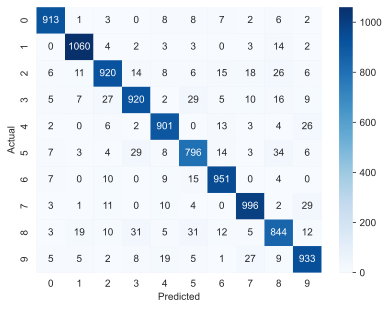

In [30]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred, model.classes_)

##### Prediction Probability Distribution for a Selected Class

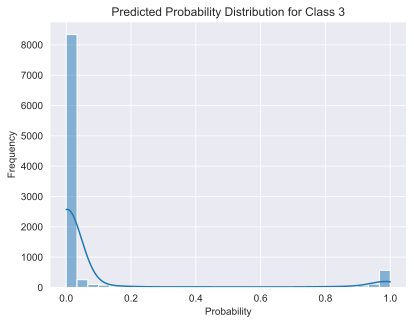

In [31]:
def plot_prediction_probabilities(model, X_test, class_idx):
    probabilities = model.predict_proba(X_test)[:, class_idx]
    sns.histplot(probabilities, kde=True, bins=30)
    plt.title(f'Predicted Probability Distribution for Class {class_idx}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_probabilities(model, X_test, class_idx=3)

##### Sample Digit Visualization

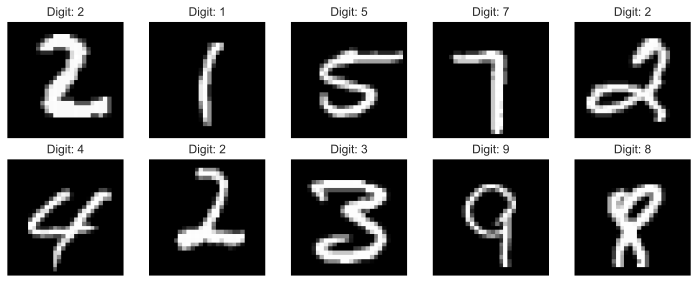

In [32]:
def plot_digits(samples, labels, n_rows=2, n_cols=5):
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Digit: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits(X_test[:10], y_pred[:10])

In [33]:
from jupyterquiz import display_quiz
display_quiz("quizzes/math.json")

<IPython.core.display.Javascript object>

# Example: Iris dataset

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import plotly.express as px
import pandas as pd

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data  # All features from the Iris dataset
y = iris.target  # Target values (species of Iris)
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
# For visualization, select two features. 
# These indices can be changed to select different features
feature_x_index = 0  # Index for the first feature used for plotting
feature_y_index = 1  # Index for the second feature used for plotting

# Create a meshgrid for plotting decision boundaries
# Adjust the limits based on the selected features for visualization
x_min, x_max = X[:, feature_x_index].min() - .5, X[:, feature_x_index].max() + .5
y_min, y_max = X[:, feature_y_index].min() - .5, X[:, feature_y_index].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))


### 3D Scatter Plot

In [35]:
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal length (cm)', color='species')
fig.show()

### Model Building

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the classifiers to be used
classifiers = {
    'L1 logistic (Multinomial)': LogisticRegression(C=10, penalty='l1',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000, 
                                                    random_state=42),  # Regularization strength, penalty, solver, class type, and maximum iterations for convergence
    'L2 logistic (Multinomial)': LogisticRegression(C=10, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000, 
                                                    random_state=42),
    'L2 logistic (OvR)': LogisticRegression(C=10, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000, 
                                            random_state=42),  # 'ovr' stands for One-vs-Rest
}


### Model Evaluation

Accuracy (train) for L1 logistic (Multinomial): 98.0%
Accuracy (train) for L2 logistic (Multinomial): 98.0%
Accuracy (train) for L2 logistic (OvR): 98.0%


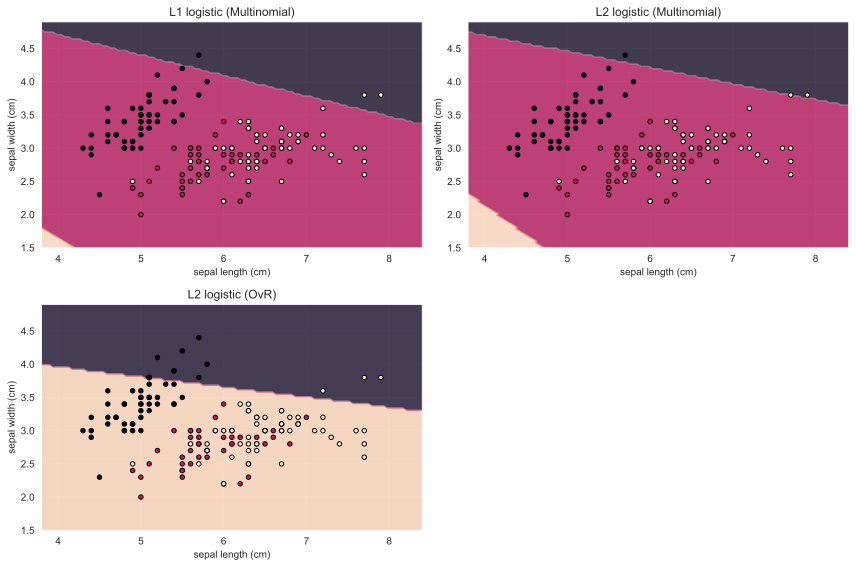

In [37]:
plt.figure(figsize=(12, 8))

# Iterate over each classifier for training and evaluation
for index, (name, classifier) in enumerate(classifiers.items()):
    # Train each classifier using the full feature set
    classifier.fit(X, y)

    # Predict using the trained classifier
    y_pred = classifier.predict(X)

    # Calculate and print the accuracy of the classifier
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for {}: {:.1f}%".format(name, accuracy * 100))

    # Plotting decision regions for visualization
    # Use mean values for the non-plotted features
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel(), 
                                 np.repeat(iris.data[:, 2].mean(), xx.ravel().size), 
                                 np.repeat(iris.data[:, 3].mean(), xx.ravel().size)])
    Z = Z.reshape(xx.shape)

    plt.subplot(2, 2, index + 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, feature_x_index], X[:, feature_y_index], c=y, edgecolor='k', s=20)
    plt.title(name)
    plt.xlabel(iris.feature_names[feature_x_index])
    plt.ylabel(iris.feature_names[feature_y_index])

plt.tight_layout()
plt.show()


L1 Logistic (Multinomial): The decision boundary is more blocky or has sharp changes, which is characteristic of L1 regularization promoting sparsity in the model.

L2 Logistic (Multinomial): The decision boundaries are smoother compared to L1, which is typical for L2 regularization as it tends to distribute weights more evenly and does not promote sparsity.

L2 Logistic (OvR): The One-vs-Rest approach seems to create distinct regions for each class, but the boundaries are somewhat similar to the L2 multinomial logistic regression. This is not surprising given the nature of the Iris dataset and the similarity of the L2 penalty in both cases.

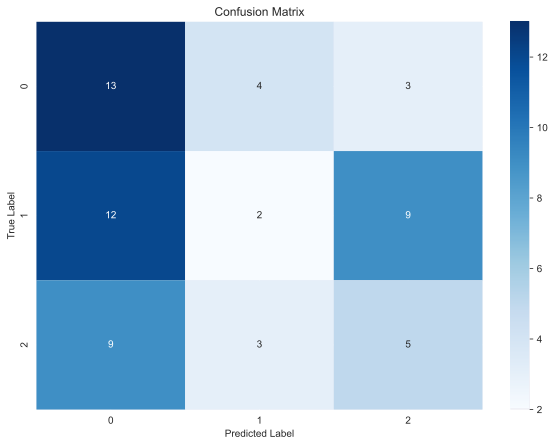

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(42)
data = pd.DataFrame({
    'Age': np.random.randint(18, 65, size=200),
    'Income': np.random.randint(30000, 80000, size=200),
    'Browsing_History': np.random.randint(0, 100, size=200),
    'Past_Purchases': np.random.randint(0, 50, size=200),
    'Customer_Segment': np.random.choice(['High-Spenders', 'Bargain Hunters', 'Occasional Shoppers'], size=200)
})

features = ['Age', 'Income', 'Browsing_History', 'Past_Purchases']
target = 'Customer_Segment'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Interactive plots


In [39]:
def plot_results(X_pca, y_true, y_pred):
    # Create a single subplot
    fig = make_subplots(rows=1, cols=1, subplot_titles=('True vs Predicted Labels'))

    # Add scatter plot for true labels
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                             marker=dict(color=y_true, size=5, colorscale='Viridis', symbol='circle'),
                             name='True Label'), row=1, col=1)

    # Add scatter plot for predicted labels
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                             marker=dict(color=y_pred, size=5, colorscale='Viridis', symbol='x'),
                             name='Predicted Label'), row=1, col=1)

    # Update layout
    fig.update_layout(height=400, width=600, title_text="PCA of MNIST Data with True and Predicted Labels")

    # Show figure
    fig.show()


In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import ipywidgets as widgets

# Load and normalize MNIST data
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X = X / 255.0
Y = Y.astype(int)

# Subsample the data for quicker processing
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, _ in sss.split(X, Y):
    X_sub, Y_sub = X[train_index], Y[train_index]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_sub)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_sub, test_size=0.2, random_state=42)

# Define the training and evaluation function
def train_and_evaluate(C, max_iter, solver):
    # Create logistic regression model
    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, multi_class='multinomial')
    # Fit the model
    model.fit(X_train, y_train)
    # Predict the classes
    y_pred = model.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model trained with C={C}, max_iter={max_iter}, solver='{solver}'")
    print(f"Model Accuracy: {accuracy:.2f}")

    # Call the plot_results function
    plot_results(X_test, y_test, y_pred)

# Create interactive widgets for model parameters
C_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-4, max=4, step=0.1, description='C (Regularization strength):')
max_iter_slider = widgets.IntSlider(value=1000, min=100, max=2000, step=100, description='Max Iterations:')
solver_dropdown = widgets.Dropdown(options=['lbfgs', 'saga'], value='lbfgs', description='Solver:')

# Display the widgets and link to the train_and_evaluate function
interactive_plot = widgets.interactive(train_and_evaluate, C=C_slider, max_iter=max_iter_slider, solver=solver_dropdown)
display(interactive_plot)

interactive(children=(FloatLogSlider(value=1.0, description='C (Regularization strength):', min=-4.0), IntSlid…